In [1]:
from copy import deepcopy
from environment import Env
from tqdm import tqdm
import numpy as np


total_words = 1000
day_limit = 50
learn_days = 20

original_env = Env(total_words=total_words, day_limit=day_limit, learn_days=learn_days)
original_env.reset()

Using CPU


/opt/homebrew/Caskroom/miniforge/base/envs/RL/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


({'obs': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])},
 {})

In [2]:
env = deepcopy(original_env)

threshold = 0.5

done = False

sum_of_recall_per_day = []

for day in tqdm(range(learn_days)):
    # all_recall = np.array([env.p_recall(card_id=i) for i in range(4000)])
    learned_cards = env.revlog["card_id"].unique()
    new_cards = set(range(total_words)) - set(learned_cards)
    card_id_for_review = []
    if len(learned_cards) > 0:
        all_recall = np.array([env.p_recall(card_id=i) for i in learned_cards])
        # print(all_recall)
        sum_of_recall_per_day.append(np.sum(all_recall))
        indexes = np.where(all_recall < threshold)[0]
        if len(indexes) > 0:
            card_id_for_review = learned_cards[indexes]
    num_of_review = len(card_id_for_review)
    num_of_new = day_limit - num_of_review
    cards_id_for_learn = []
    if num_of_new > 0 and len(new_cards) > 0:
        cards_id_for_learn = np.random.choice(list(new_cards), num_of_new, replace=True)
    cards = np.concatenate([card_id_for_review, cards_id_for_learn])
    # print(f"Day {day+1}: {len(card_id_for_review)} review cards, {len(cards_id_for_learn)} new cards")
    if len(cards) < day_limit:
        cards = np.concatenate(
            [
                cards,
                np.random.choice(
                    list(learned_cards), day_limit - len(cards), replace=False
                ),
            ]
        )
    for i in range(day_limit):
        card_id = cards[i]
        state, reward, done, _, info = env.step(card_id)
        if info["response"] == 0:
            # insert card_id to cards[i+2]
            cards = np.insert(cards, min(i + 2, len(cards) - 1), card_id)
        if done:
            break
    if done:
        break

 95%|█████████▌| 19/20 [00:36<00:01,  1.92s/it]


In [3]:
sum_of_recall_per_day

[19.036676108837128,
 33.56382066011429,
 53.39573436975479,
 65.95455574989319,
 82.22074806690216,
 98.53177917003632,
 111.12535840272903,
 127.62395370006561,
 144.75213819742203,
 155.3180307149887,
 172.466093480587,
 187.40787291526794,
 200.77599370479584,
 217.4954416155815,
 235.32760351896286,
 249.10809874534607,
 265.4391161799431,
 283.7364937067032,
 298.01388359069824]

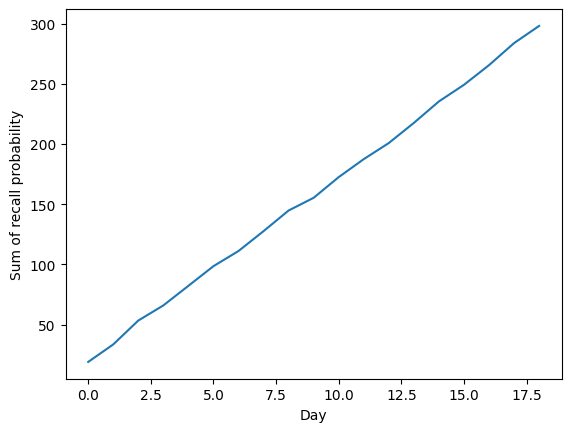

In [4]:
import matplotlib.pyplot as plt

plt.plot(sum_of_recall_per_day)
plt.xlabel("Day")
plt.ylabel("Sum of recall probability")
plt.show()

In [5]:
import torch
from torch import nn

n_input = 4
n_hidden = 32
n_output = 1
n_layers = 1
network = "GRU"


class RNN(nn.Module):
    def __init__(self, state_dict=None):
        super().__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_out = n_output
        self.n_layers = n_layers
        if network == "GRU":
            self.rnn = nn.GRU(
                input_size=self.n_input,
                hidden_size=self.n_hidden,
                num_layers=self.n_layers,
            )
        elif network == "LSTM":
            self.rnn = nn.LSTM(
                input_size=self.n_input,
                hidden_size=self.n_hidden,
                num_layers=self.n_layers,
            )
        else:
            self.rnn = nn.RNN(
                input_size=self.n_input,
                hidden_size=self.n_hidden,
                num_layers=self.n_layers,
            )

        self.fc = nn.Linear(self.n_hidden, self.n_out)

        if state_dict is not None:
            self.load_state_dict(state_dict)

    def forward(self, x, hx=None):
        x, h = self.rnn(x, hx=hx)
        output = torch.exp(self.fc(x))
        return output, h

    def full_connect(self, h):
        return self.fc(h)

    def forgetting_curve(self, t, s):
        return 0.9 ** (t / s)


state_dict = torch.load("./data/GRU-HLR.pth")
model = RNN(state_dict=state_dict)

In [6]:
def lineToTensorRNN(line, d):
    ivl = line[0].split(",")
    response = line[1].split(",")
    tensor = torch.zeros(len(response), n_input, dtype=torch.float32)
    for li, response in enumerate(response):
        tensor[li][int(response)] = 1
        tensor[li][2] = int(ivl[li])
        tensor[li][3] = d
    return tensor


tensor = lineToTensorRNN(["1,2,3,4", "0,1,0,1"], 1)

with torch.no_grad():
    output, h = model(tensor)
    print(output)

tensor([[1.0540],
        [4.4724],
        [1.6603],
        [6.1776]])


In [7]:
env = deepcopy(original_env)

threshold = 0.5

done = False

sum_of_recall_per_day = []

for day in tqdm(range(learn_days)):
    learned_cards = env.revlog["card_id"].unique()
    new_cards = set(range(total_words)) - set(learned_cards)
    card_id_for_review = []
    if len(learned_cards) > 0:
        all_recall = np.array([env.p_recall(card_id=i) for i in learned_cards])
        # print(all_recall)
        sum_of_recall_per_day.append(np.sum(all_recall))
        revlog = env.revlog[env.revlog["repeat_time_inday"] == 1].copy()
        revlog.sort_values(by=["card_id", "review_day_th"], inplace=True)
        revlog["delta_t"] = revlog.review_day_th.diff()
        revlog["delta_t"] = revlog["delta_t"].fillna(0)
        revlog["delta_t"] = revlog["delta_t"].astype(int)
        revlog["Y"] = revlog["Y"].astype(int)
        t_history = (
            revlog.groupby(by=["card_id"], group_keys=False)["delta_t"]
            .apply(lambda x: [str(i) for i in x])
            .to_dict()
        )
        r_history = (
            revlog.groupby(by=["card_id"], group_keys=False)["Y"]
            .apply(lambda x: [str(i) for i in x])
            .to_dict()
        )
        difficuty = (
            revlog.groupby(by=["card_id"], group_keys=False)["difficulty"]
            .apply(lambda x: x.iloc[0])
            .to_dict()
        )

        last_review_delta_t = (
            revlog.groupby(by=["card_id"], group_keys=False)["review_day_th"]
            .apply(lambda x: day - x.iloc[-1])
            .to_dict()
        )
        with torch.no_grad():
            for card_id in learned_cards:
                t = ",".join(t_history[card_id])
                r = ",".join(r_history[card_id])
                d = difficuty[card_id]
                ivl = last_review_delta_t[card_id]
                tensor = lineToTensorRNN([t, r], d)
                output, h = model(tensor)
                retrievability = model.forgetting_curve(ivl, output[0][-1])
                if retrievability < threshold:
                    card_id_for_review.append(card_id)
                    if len(card_id_for_review) >= day_limit:
                        break

    num_of_review = len(card_id_for_review)
    num_of_new = day_limit - num_of_review
    cards_id_for_learn = []
    if num_of_new > 0 and len(new_cards) > 0:
        cards_id_for_learn = np.random.choice(list(new_cards), num_of_new, replace=True)

    cards = np.concatenate([card_id_for_review, cards_id_for_learn])
    if len(cards) < day_limit:
        cards = np.concatenate(
            [
                cards,
                np.random.choice(
                    list(learned_cards), day_limit - len(cards), replace=False
                ),
            ]
        )

    for i in range(day_limit):
        card_id = cards[i]
        state, reward, done, _, info = env.step(card_id)
        if info["response"] == 0:
            # insert card_id to cards[i+2]
            cards = np.insert(cards, min(i + 2, len(cards) - 1), card_id)
        if done:
            break

100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


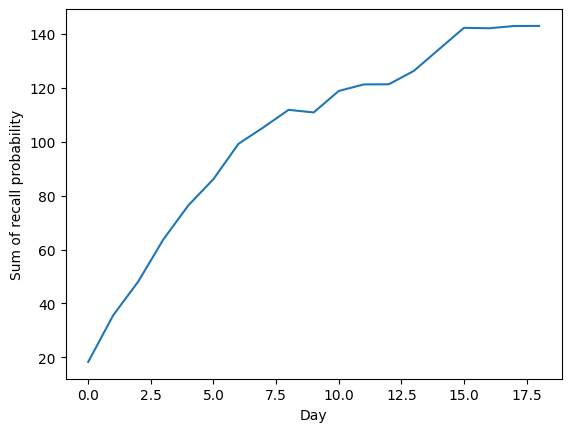

In [8]:
import matplotlib.pyplot as plt

plt.plot(sum_of_recall_per_day)
plt.xlabel("Day")
plt.ylabel("Sum of recall probability")
plt.show()

In [9]:
import torch
from torch import nn
from typing import List, Optional
from torch import Tensor

class FSRS4(nn.Module):
    init_w = [0, 0, 4.93, -0.94, -0.86, 0.01, 1.49, -0.14, 0.94, 2.18, -0.05, 0.34, 1.26, 0, 0]
    def __init__(self, w: List[float] = init_w, state_dict=None):
        super(FSRS4, self).__init__()
        self.w = nn.Parameter(torch.tensor(w, dtype=torch.float32))
        self.s0 = nn.Parameter(torch.tensor([1, 2, 3, 4], dtype=torch.float32))
        if state_dict is not None:
            self.load_state_dict(state_dict)

    def forgetting_curve(self, t, s):
        return (1 + t / (9 * s)) ** -1

    def stability_after_success(self, state: Tensor, new_d: Tensor, r: Tensor, rating: Tensor) -> Tensor:
        new_s = state[:,0] * (1 + torch.exp(self.w[6]) *
                        (11 - new_d) *
                        torch.pow(state[:,0], self.w[7]) *
                        (torch.exp((1 - r) * self.w[8]) - 1))
        return new_s

    def stability_after_failure(self, state: Tensor, new_d: Tensor, r: Tensor) -> Tensor:
        new_s = self.w[9] * \
                torch.pow(new_d, self.w[10]) * \
                (torch.pow(state[:,0] + 1, self.w[11]) - 1) * \
                torch.exp((1 - r) * self.w[12])
        return new_s

    def step(self, X: Tensor, state: Tensor) -> Tensor:
        '''
        :param X: shape[batch_size, 2], X[:,0] is elapsed time, X[:,1] is rating
        :param state: shape[batch_size, 2], state[:,0] is stability, state[:,1] is difficulty
        :return state:
        '''
        if torch.equal(state, torch.zeros_like(state)):
            keys = torch.tensor([1, 2, 3, 4])
            keys = keys.view(1, -1).expand(X[:,1].long().size(0), -1)
            index = (X[:,1].long().unsqueeze(1) == keys).nonzero(as_tuple=True)
            # first learn, init memory states
            new_s = self.s0[index[1]] + (self.w[0] * X[:,2] + self.w[1])
            new_d = self.w[2] + self.w[3] * (X[:,1] - 3) + (self.w[13] * X[:,2] + self.w[14])
            new_d = new_d.clamp(1, 10)
        else:
            r = self.forgetting_curve(X[:,0], state[:,0])
            new_d = state[:,1] + self.w[4] * (X[:,1] - 3)
            new_d = self.mean_reversion(self.w[2], new_d)
            new_d = new_d.clamp(1, 10)
            condition = X[:,1] > 1
            new_s = torch.where(condition, self.stability_after_success(state, new_d, r, X[:,1]), self.stability_after_failure(state, new_d, r))
        new_s = new_s.clamp(0.1, 36500)
        return torch.stack([new_s, new_d], dim=1)

    def forward(self, inputs: Tensor, state: Optional[Tensor]=None) -> Tensor:
        '''
        :param inputs: shape[seq_len, batch_size, 2]
        '''
        if state is None:
            state = torch.zeros((inputs.shape[1], 2))
        outputs = []
        for X in inputs:
            state = self.step(X, state)
            outputs.append(state)
        return torch.stack(outputs), state

    def mean_reversion(self, init: Tensor, current: Tensor) -> Tensor:
        return self.w[5] * init + (1-self.w[5]) * current
    


state_dict = torch.load("./data/DHP-HLR.pth")
model = FSRS4(state_dict=state_dict)

In [10]:
def lineToTensor(line: str, d) -> Tensor:
    ivl = line[0].split(',')
    response = line[1].split(',')
    tensor = torch.zeros(len(response), 3)
    for li, response in enumerate(response):
        tensor[li][0] = int(ivl[li])
        tensor[li][1] = int(response)
        tensor[li][2] = np.sqrt(d)
    return tensor

tensor = lineToTensor(["1,2,3,4", "1,3,1,3"], 1)

tensor = tensor.unsqueeze(1)

with torch.no_grad():
    output, h = model(tensor)
    print(output)

tensor([[[0.9366, 6.9458]],

        [[3.5437, 6.9457]],

        [[1.2842, 7.5399]],

        [[5.3482, 7.5398]]])


In [11]:
env = deepcopy(original_env)

threshold = 0.5

done = False

sum_of_recall_per_day = []

for day in tqdm(range(learn_days)):
    learned_cards = env.revlog["card_id"].unique()
    new_cards = set(range(total_words)) - set(learned_cards)
    card_id_for_review = []
    if len(learned_cards) > 0:
        all_recall = np.array([env.p_recall(card_id=i) for i in learned_cards])
        # print(all_recall)
        sum_of_recall_per_day.append(np.sum(all_recall))
        revlog = env.revlog[env.revlog["repeat_time_inday"] == 1].copy()
        revlog.sort_values(by=["card_id", "review_day_th"], inplace=True)
        revlog["delta_t"] = revlog.review_day_th.diff()
        revlog["delta_t"] = revlog["delta_t"].fillna(0)
        revlog["delta_t"] = revlog["delta_t"].astype(int)
        revlog["Y"] = revlog["Y"].astype(int)
        t_history = (
            revlog.groupby(by=["card_id"], group_keys=False)["delta_t"]
            .apply(lambda x: [str(i) for i in x])
            .to_dict()
        )
        r_history = (
            revlog.groupby(by=["card_id"], group_keys=False)["Y"]
            .apply(lambda x: [str(i) for i in x])
            .to_dict()
        )
        difficuty = (
            revlog.groupby(by=["card_id"], group_keys=False)["difficulty"]
            .apply(lambda x: x.iloc[0])
            .to_dict()
        )

        last_review_delta_t = (
            revlog.groupby(by=["card_id"], group_keys=False)["review_day_th"]
            .apply(lambda x: day - x.iloc[-1])
            .to_dict()
        )
        with torch.no_grad():
            for card_id in learned_cards:
                t = ",".join(t_history[card_id])
                r = ",".join(r_history[card_id]).replace('1', '3').replace('0', '1')
                d = difficuty[card_id]
                ivl = last_review_delta_t[card_id]
                tensor = lineToTensor([t, r], d).unsqueeze(1)
                output, h = model(tensor)
                stabilities = output[-1,:,0]
                retrievability = model.forgetting_curve(ivl, stabilities)
                if retrievability < threshold:
                    card_id_for_review.append(card_id)
                    if len(card_id_for_review) >= day_limit:
                        break

    num_of_review = len(card_id_for_review)
    num_of_new = day_limit - num_of_review
    cards_id_for_learn = []
    if num_of_new > 0 and len(new_cards) > 0:
        cards_id_for_learn = np.random.choice(list(new_cards), num_of_new, replace=True)

    cards = np.concatenate([card_id_for_review, cards_id_for_learn])
    if len(cards) < day_limit:
        cards = np.concatenate(
            [
                cards,
                np.random.choice(
                    list(learned_cards), day_limit - len(cards), replace=False
                ),
            ]
        )

    for i in range(day_limit):
        card_id = cards[i]
        state, reward, done, _, info = env.step(card_id)
        if info["response"] == 0:
            # insert card_id to cards[i+2]
            cards = np.insert(cards, min(i + 2, len(cards) - 1), card_id)
        if done:
            break

100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


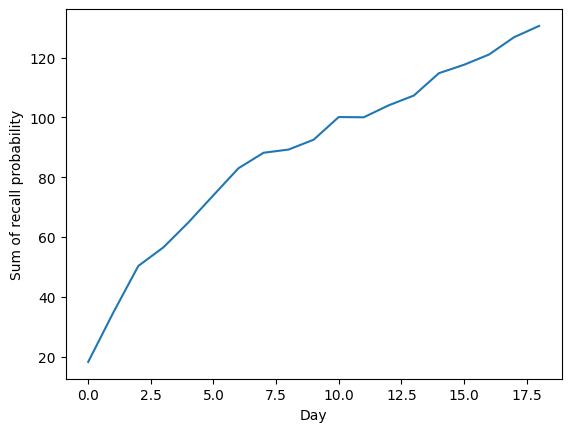

In [12]:
import matplotlib.pyplot as plt

plt.plot(sum_of_recall_per_day)
plt.xlabel("Day")
plt.ylabel("Sum of recall probability")
plt.show()

In [13]:
class HLR(nn.Module):
    def __init__(self, state_dict=None):
        super().__init__()
        self.n_input = 3
        self.n_out = 1
        self.fc = nn.Linear(self.n_input, self.n_out)

        if state_dict is not None:
            self.load_state_dict(state_dict)

    def forward(self, x):
        dp = self.fc(x)
        return 2 ** dp, None

    def forgetting_curve(self, t, s):
        return 0.5 ** (t / s)
    

state_dict = torch.load("./data/HLR.pth")
model = HLR(state_dict=state_dict)

In [14]:
t_history = "0,1,4,8"
r_history = "0,1,0,1"

wrong = r_history.count("0")
right = r_history.count("1")
difficuty = 6

tensor = torch.tensor([np.sqrt(right), np.sqrt(wrong), np.sqrt(difficuty)], dtype=torch.float32)

with torch.no_grad():
    output, h = model(tensor)
    print(output)

tensor([20.1531])


In [17]:
env = deepcopy(original_env)

threshold = 0.5

done = False

sum_of_recall_per_day = []

for day in tqdm(range(learn_days)):
    learned_cards = env.revlog["card_id"].unique()
    new_cards = set(range(total_words)) - set(learned_cards)
    card_id_for_review = []
    if len(learned_cards) > 0:
        all_recall = np.array([env.p_recall(card_id=i) for i in learned_cards])
        # print(all_recall)
        sum_of_recall_per_day.append(np.sum(all_recall))
        revlog = env.revlog[env.revlog["repeat_time_inday"] == 1].copy()
        revlog.sort_values(by=["card_id", "review_day_th"], inplace=True)
        revlog["delta_t"] = revlog.review_day_th.diff()
        revlog["delta_t"] = revlog["delta_t"].fillna(0)
        revlog["delta_t"] = revlog["delta_t"].astype(int)
        revlog["Y"] = revlog["Y"].astype(int)
        t_history = (
            revlog.groupby(by=["card_id"], group_keys=False)["delta_t"]
            .apply(lambda x: [str(i) for i in x])
            .to_dict()
        )
        r_history = (
            revlog.groupby(by=["card_id"], group_keys=False)["Y"]
            .apply(lambda x: [str(i) for i in x])
            .to_dict()
        )
        difficuty = (
            revlog.groupby(by=["card_id"], group_keys=False)["difficulty"]
            .apply(lambda x: x.iloc[0])
            .to_dict()
        )

        last_review_delta_t = (
            revlog.groupby(by=["card_id"], group_keys=False)["review_day_th"]
            .apply(lambda x: day - x.iloc[-1])
            .to_dict()
        )
        with torch.no_grad():
            for card_id in learned_cards:
                t = ",".join(t_history[card_id])
                r = ",".join(r_history[card_id]).replace('1', '3').replace('0', '1')
                wrong = r.count("0")
                right = r.count("1")
                d = difficuty[card_id]
                ivl = last_review_delta_t[card_id]
                tensor = torch.tensor([np.sqrt(right), np.sqrt(wrong), np.sqrt(d)], dtype=torch.float32)
                output, h = model(tensor)
                retrievability = model.forgetting_curve(ivl, output)
                if retrievability < threshold:
                    card_id_for_review.append(card_id)
                    if len(card_id_for_review) >= day_limit:
                        break

    num_of_review = len(card_id_for_review)
    num_of_new = day_limit - num_of_review
    cards_id_for_learn = []
    if num_of_new > 0 and len(new_cards) > 0:
        cards_id_for_learn = np.random.choice(list(new_cards), num_of_new, replace=True)

    cards = np.concatenate([card_id_for_review, cards_id_for_learn])
    if len(cards) < day_limit:
        cards = np.concatenate(
            [
                cards,
                np.random.choice(
                    list(learned_cards), day_limit - len(cards), replace=False
                ),
            ]
        )

    for i in range(day_limit):
        card_id = cards[i]
        state, reward, done, _, info = env.step(card_id)
        if info["response"] == 0:
            # insert card_id to cards[i+2]
            cards = np.insert(cards, min(i + 2, len(cards) - 1), card_id)
        if done:
            break

100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


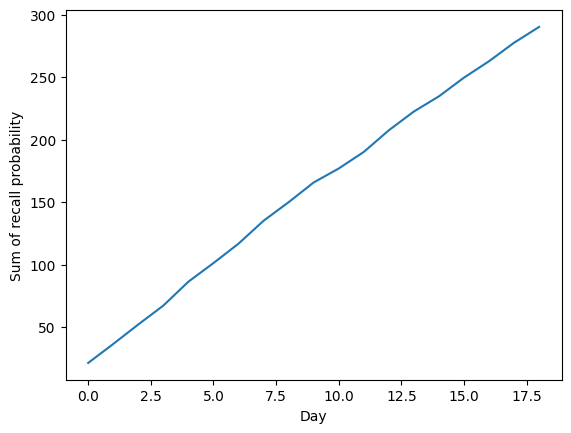

In [18]:
import matplotlib.pyplot as plt

plt.plot(sum_of_recall_per_day)
plt.xlabel("Day")
plt.ylabel("Sum of recall probability")
plt.show()